In [2]:
import pandas as pd

In [3]:
df_imdb = pd.read_csv('../datasets/IMDB-Movie-Data.csv')
df_imdb.sample(5)

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
741,742,Hands of Stone,"Action,Biography,Drama",The legendary Roberto Duran and his equally le...,Jonathan Jakubowicz,"Edgar Ramírez, Usher Raymond, Robert De Niro, ...",2016,111,6.6,8998,4.71,54.0
851,852,Begin Again,"Drama,Music",A chance encounter between a disgraced music-b...,John Carney,"Keira Knightley, Mark Ruffalo, Adam Levine, Ha...",2013,104,7.4,111875,16.17,62.0
310,311,The Blind Side,"Biography,Drama,Sport","The story of Michael Oher, a homeless and trau...",John Lee Hancock,"Quinton Aaron, Sandra Bullock, Tim McGraw,Jae ...",2009,129,7.7,237221,255.95,53.0
672,673,The Hurt Locker,"Drama,History,Thriller","During the Iraq War, a Sergeant recently assig...",Kathryn Bigelow,"Jeremy Renner, Anthony Mackie, Brian Geraghty,...",2008,131,7.6,352023,15.70,94.0
553,554,The Survivalist,"Drama,Sci-Fi,Thriller","In a time of starvation, a survivalist lives o...",Stephen Fingleton,"Mia Goth, Martin McCann, Barry Ward, Andrew Si...",2015,104,6.3,9187,NaN,80.0


## Preliminary text exploration
Before we proceed with any text pre-processing, it is advisable to quickly explore the dataset in terms of word counts, most common and most uncommon words.

## Fetch word count for each abstract


In [120]:
#df_imdb["Word_count"] = df_imdb['Description'].apply(lambda x: str(x.lower()).replace("see full sumary", ""))
df_imdb["Word_count"] = df_imdb['Description'].apply(lambda x: len(str(x).split(" ")))
df_imdb["Genre"] = df_imdb["Genre"].apply(lambda x: str(x).replace(",", " ").replace("-","").split(" "))
df_imdb["Actors"] = df_imdb["Actors"].apply(lambda x: str(x).replace(" ", "").replace("-","").split(","))
#df_imdb["Director"] = df_imdb["Director"].apply(lambda x: str(x).replace(" ", "").replace("-","").split(","))
df_imdb["Runtime (Minutes)"] = (df_imdb["Runtime (Minutes)"].max() - df_imdb["Runtime (Minutes)"]) /(df_imdb["Runtime (Minutes)"].max() - df_imdb["Runtime (Minutes)"].min())
df_imdb["Year"] = (df_imdb["Year"].max() - df_imdb["Year"]) /(df_imdb["Year"].max() - df_imdb["Year"].min())
df_imdb.head() 
pd.get_dummies(df_imdb['Director'])

TypeError: unhashable type: 'list'

In [115]:
df_imdb["Word_count"].describe()


count    1000.000000
mean       27.921000
std         8.727022
min         8.000000
25%        22.000000
50%        27.000000
75%        34.000000
max        72.000000
Name: Word_count, dtype: float64

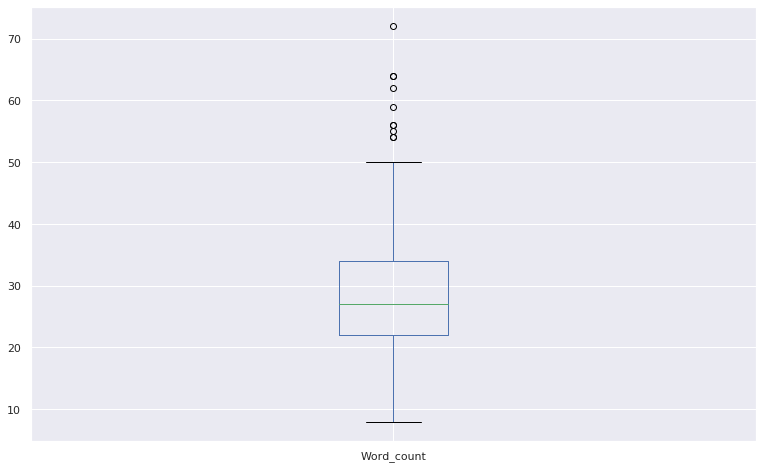

In [81]:
df_imdb.boxplot(column="Word_count")

The word count is important to give us an indication of the size of the dataset that we are handling as well as the variation in word counts across the rows.
## Most common and uncommon words
A peek into the most common words gives insights not only on the frequently used words but also words that could also be potential data specific stop words. A comparison of the most common words and the default English stop words will give us a list of words that need to be added to a custom stop word list.



In [82]:
# Frequência das palavras
freq = pd.Series(' '.join(df_imdb['Description']).split()).value_counts()
freq.describe()

count    7645.000000
mean        3.652191
std        29.334334
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max      1284.000000
dtype: float64

In [83]:
#Identify common words
common = freq[:20]
common

a        1284
the      1240
to        933
of        806
and       712
in        495
his       479
A         342
is        294
with      263
an        259
her       234
on        218
their     217
for       196
who       185
by        182
he        171
that      167
from      153
dtype: int64

In [84]:
#Identify uncommon words
uncommon =  freq[-20:]
uncommon

Reich's         1
badges          1
orphans         1
Later           1
Identical       1
employing       1
fiancée's       1
interlocking    1
salesmen        1
giants          1
revolution      1
habits          1
drama,          1
1930s,          1
McGrath         1
smuggling       1
bosses          1
geologist       1
trip.           1
Nigeria,        1
dtype: int64

## Text Pre-processing
Text pre-processing can be divided into two broad categories — noise removal & normalization. Data components that are redundant to the core text analytics can be considered as noise.

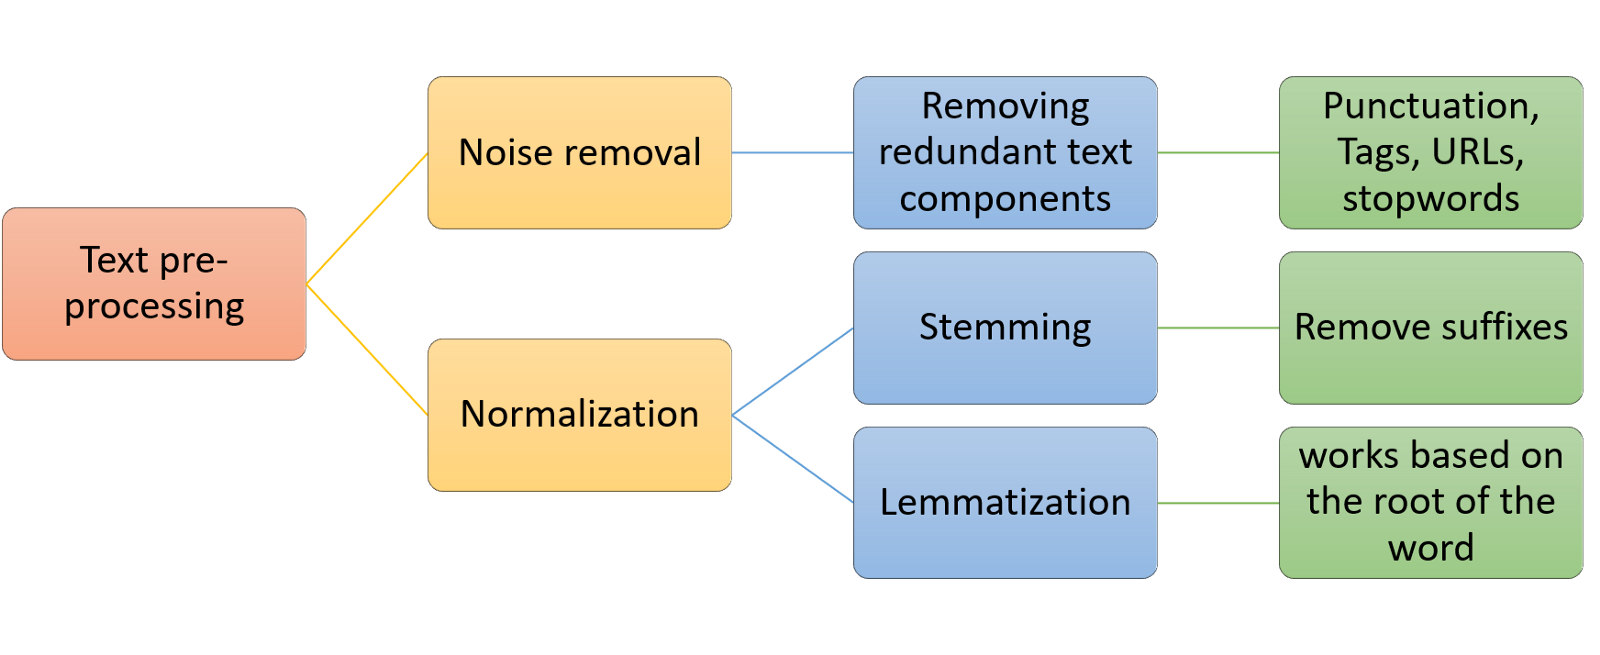

Handling multiple occurrences / representations of the same word is called normalization. There are two types of normalization — stemming and lemmatization. Let us consider an example of various versions of the word learn — learn, learned, learning, learner. Normalisation will convert all these words to a single normalised version — “learn”.

Stemming normalizes text by removing suffixes.

Lemmatisation is a more advanced technique which works based on the root of the word.

#### To carry out text pre-processing on our dataset, we will first import the required libraries.

In [85]:
# Libraries for text preprocessing
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer

__Removing stopwords__: Stop words include the large number of prepositions, pronouns, conjunctions etc in sentences. These words need to be removed before we analyse the text, so that the frequently used words are mainly the words relevant to the context and not common words used in the text.

There is a default list of stopwords in python nltk library. In addition, we might want to add context specific stopwords for which the “most common words” that we listed in the beginning will be helpful. We will now see how to create a list of stopwords and how to add custom stopwords:

In [86]:
##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))

##Creating a list of custom stopwords
#new_words = ["using", "show", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown"]
#stop_words = stop_words.union(new_words)

We will now carry out the pre-processing tasks step-by-step to get a cleaned and normalised text corpus:

In [88]:
corpus = []
for i in range(0, df_imdb.shape[0]):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', df_imdb['Description'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [89]:
corpus[0]

'group intergalactic criminal forced work together stop fanatical warrior taking control universe'

## Data Exploration
We will now visualize the text corpus that we created after pre-processing to get insights on the most frequently used words.

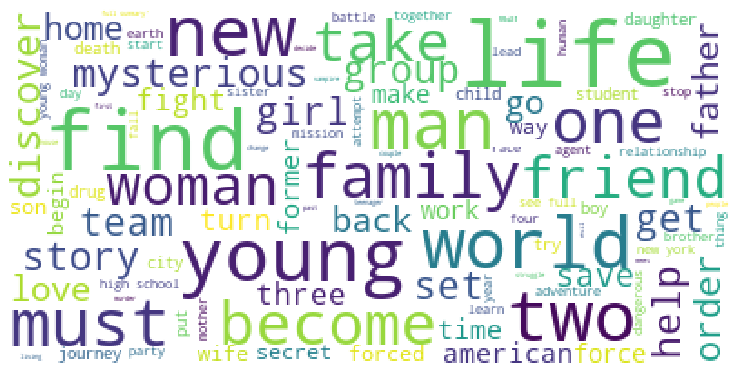

In [90]:
#Word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

## Text preparation
Text in the corpus needs to be converted to a format that can be interpreted by the machine learning algorithms. There are 2 parts of this conversion — Tokenisation and Vectorisation.

_Tokenisation is the process of converting the continuous text into a list of words. The list of words is then converted to a matrix of integers by the process of vectorisation. Vectorisation is also called feature extraction._

For text preparation we use the bag of words model which ignores the sequence of the words and only considers word frequencies.

## Creating a vector of word counts

As the first step of conversion, we will use the CountVectoriser to tokenise the text and build a vocabulary of known words. We first create a variable “cv” of the CountVectoriser class, and then evoke the fit_transform function to learn and build the vocabulary.

In [91]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

Let us now understand the parameters passed into the function:

    max_df — When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). This is to ensure that we only have words relevant to the context and not commonly used words.
    
    max_features — determines the number of columns in the matrix.
    
    n-gram range — we would want to look at a list of single words, two words (bi-grams) and three words (tri-gram) combinations.
An encoded vector is returned with a length of the entire vocabulary.

In [92]:
list(cv.vocabulary_.keys())[:10]

['group',
 'intergalactic',
 'criminal',
 'forced',
 'work',
 'together',
 'stop',
 'warrior',
 'taking',
 'control']

## Visualize top N uni-grams, bi-grams & tri-grams

We can use the CountVectoriser to visualise the top 20 unigrams, bi-grams and tri-grams.

[Text(0, 0, 'life'),
 Text(0, 0, 'young'),
 Text(0, 0, 'find'),
 Text(0, 0, 'new'),
 Text(0, 0, 'world'),
 Text(0, 0, 'man'),
 Text(0, 0, 'two'),
 Text(0, 0, 'friend'),
 Text(0, 0, 'woman'),
 Text(0, 0, 'family'),
 Text(0, 0, 'must'),
 Text(0, 0, 'one'),
 Text(0, 0, 'year'),
 Text(0, 0, 'take'),
 Text(0, 0, 'story'),
 Text(0, 0, 'girl'),
 Text(0, 0, 'love'),
 Text(0, 0, 'mysterious'),
 Text(0, 0, 'get'),
 Text(0, 0, 'group')]

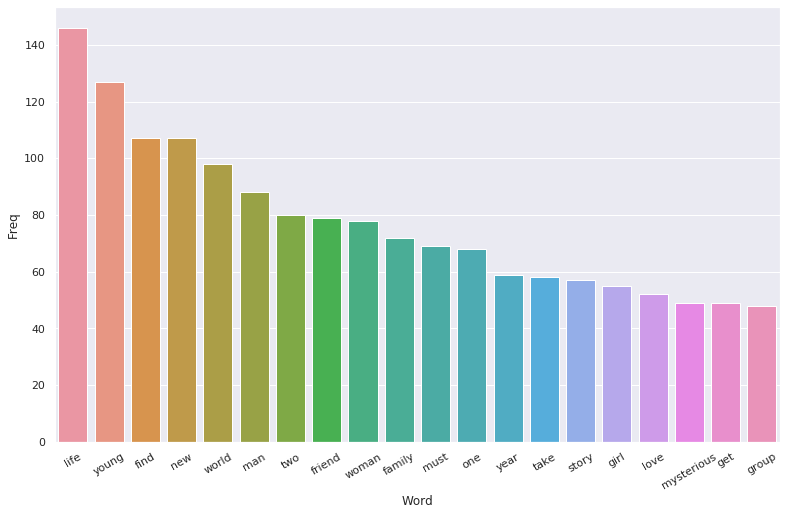

In [93]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

         Bi-gram  Freq
0    high school    24
1    young woman    24
2       new york    22
3       see full    20
4   full summary    20
5       year old    17
6    best friend    17
7    los angeles    16
8      young man    12
9     small town    11
10     york city    10
11     young boy     8
12    th century     8
13     world war     8
14     cia agent     8
15     fall love     8
16  group friend     7
17    young girl     7
18    true story     7
19     fbi agent     7


[Text(0, 0, 'high school'),
 Text(0, 0, 'young woman'),
 Text(0, 0, 'new york'),
 Text(0, 0, 'see full'),
 Text(0, 0, 'full summary'),
 Text(0, 0, 'year old'),
 Text(0, 0, 'best friend'),
 Text(0, 0, 'los angeles'),
 Text(0, 0, 'young man'),
 Text(0, 0, 'small town'),
 Text(0, 0, 'york city'),
 Text(0, 0, 'young boy'),
 Text(0, 0, 'th century'),
 Text(0, 0, 'world war'),
 Text(0, 0, 'cia agent'),
 Text(0, 0, 'fall love'),
 Text(0, 0, 'group friend'),
 Text(0, 0, 'young girl'),
 Text(0, 0, 'true story'),
 Text(0, 0, 'fbi agent')]

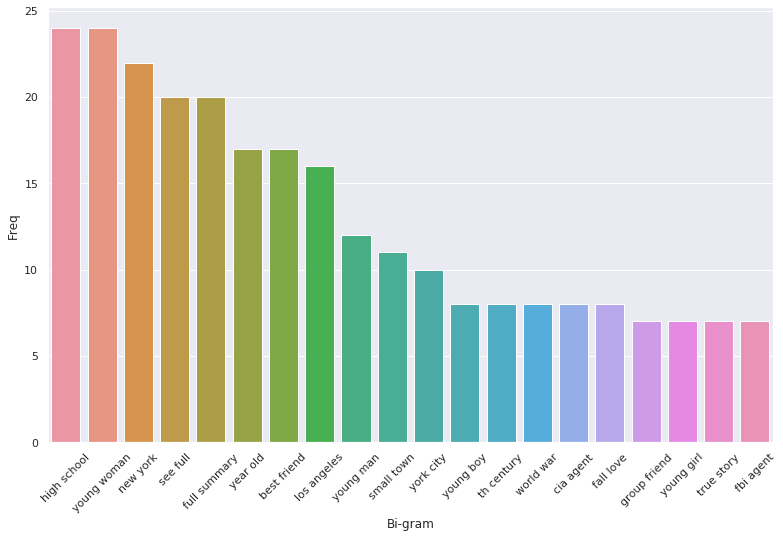

In [94]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

                 Tri-gram  Freq
0        see full summary    20
1           new york city    10
2            world war ii     6
3      high school senior     5
4          eight year old     4
5     change life forever     3
6     high school student     3
7         half human half     3
8   save world apocalypse     2
9       must unite defeat     2
10      behind enemy line     2
11   earth mightiest hero     2
12       france world war     2
13     band together stop     2
14       based true story     2
15       take matter hand     2
16   civil right movement     2
17         twin peak fire     2
18         peak fire walk     2
19     must band together     2


[Text(0, 0, 'see full summary'),
 Text(0, 0, 'new york city'),
 Text(0, 0, 'world war ii'),
 Text(0, 0, 'high school senior'),
 Text(0, 0, 'eight year old'),
 Text(0, 0, 'change life forever'),
 Text(0, 0, 'high school student'),
 Text(0, 0, 'half human half'),
 Text(0, 0, 'save world apocalypse'),
 Text(0, 0, 'must unite defeat'),
 Text(0, 0, 'behind enemy line'),
 Text(0, 0, 'earth mightiest hero'),
 Text(0, 0, 'france world war'),
 Text(0, 0, 'band together stop'),
 Text(0, 0, 'based true story'),
 Text(0, 0, 'take matter hand'),
 Text(0, 0, 'civil right movement'),
 Text(0, 0, 'twin peak fire'),
 Text(0, 0, 'peak fire walk'),
 Text(0, 0, 'must band together')]

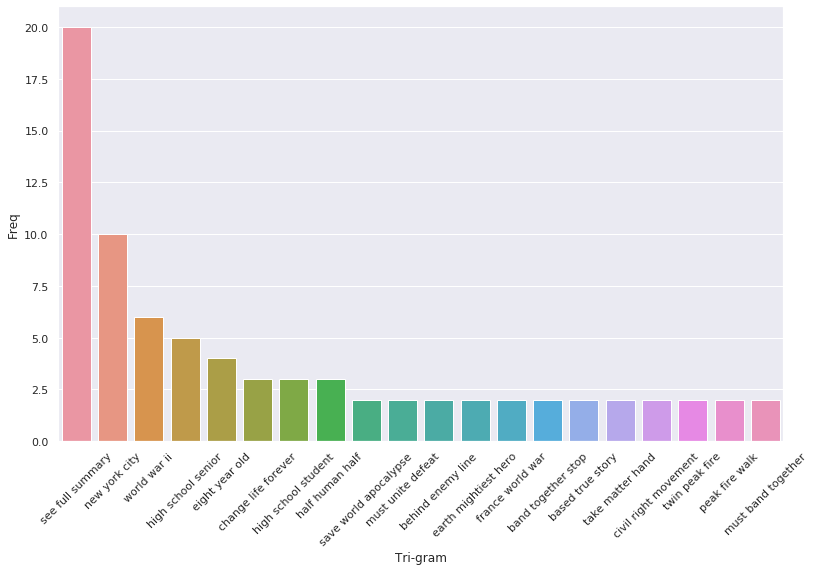

In [95]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)

## Converting to a matrix of integers
The next step of refining the word counts is using the TF-IDF vectoriser. The deficiency of a mere word count obtained from the countVectoriser is that, large counts of certain common words may dilute the impact of more context specific words in the corpus. This is overcome by the TF-IDF vectoriser which penalizes words that appear several times across the document. TF-IDF are word frequency scores that highlight words that are more important to the context rather than those that appear frequently across documents.

TF-IDF consists of 2 components:

    TF — term frequency
    IDF — Inverse document frequency
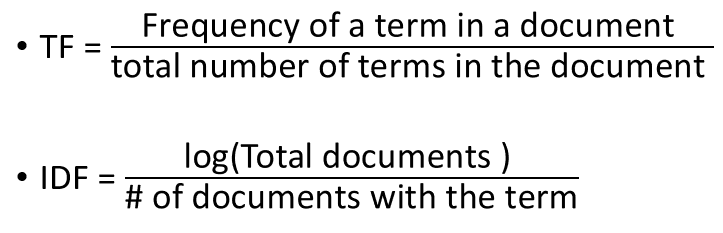


In [101]:
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()

# fetch document for which keywords needs to be extracted
doc=corpus[0]
 
#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))
tf_idf_vector.toarray()[0]
cv.get_feature_names()

['aang',
 'abandoned',
 'abducted',
 'ability',
 'absence',
 'abuse',
 'abusive',
 'accident',
 'accidental',
 'accidental death',
 'accidentally',
 'accompanied',
 'accomplished',
 'account',
 'accused',
 'accuses',
 'acquaintance',
 'across',
 'across europe',
 'act',
 'action',
 'activist',
 'activity',
 'actor',
 'actress',
 'actually',
 'ad',
 'ad le',
 'addicted',
 'adopt',
 'adopted',
 'adult',
 'adulthood',
 'advance',
 'adventure',
 'adventure teenager',
 'adventurous',
 'affair',
 'affected',
 'afghanistan',
 'africa',
 'african',
 'african american',
 'aftermath',
 'age',
 'aged',
 'agency',
 'agent',
 'agent infiltrates',
 'agent travel',
 'aging',
 'ago',
 'agrees',
 'aid',
 'aided',
 'aided search',
 'aided search woman',
 'alabama',
 'alex',
 'alice',
 'alice return',
 'alien',
 'alien race',
 'alive',
 'alliance',
 'ally',
 'almost',
 'alone',
 'along',
 'along way',
 'alongside',
 'alp',
 'also',
 'alter',
 'alter ego',
 'altered',
 'alternate',
 'alternative',
 'alway

Based on the TF-IDF scores, we can extract the words with the highest scores to get the keywords for a document.

In [97]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,5)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
group intergalactic criminal forced work together stop fanatical warrior taking control universe

Keywords:
forced work 0.333
together stop 0.319
intergalactic 0.308
work together 0.299
universe 0.291


In [98]:
keywords

{'forced work': 0.333,
 'together stop': 0.319,
 'intergalactic': 0.308,
 'work together': 0.299,
 'universe': 0.291}

In [99]:
tf_idf_X =tfidf_transformer.transform(X)
tf_idf_X.toarray().shape

(1000, 10000)

In [100]:
new_df = pd.DataFrame(tf_idf_X.toarray(), index=df_imdb.Title)
new_df[""]

In [53]:
new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
Title,,,,,,,,,,,,,,,,,,,,,
Guardians of the Galaxy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Prometheus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Split,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Suicide Squad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
from sklearn.metrics.pairwise import cosine_similarity
sim = cosine_similarity(new_df)

In [61]:
sim = pd.DataFrame(sim,index=df_imdb.Title ,columns=df_imdb.Title)
sim.index

Index(['Guardians of the Galaxy', 'Prometheus', 'Split', 'Sing',
       'Suicide Squad', 'The Great Wall', 'La La Land', 'Mindhorn',
       'The Lost City of Z', 'Passengers',
       ...
       'Underworld: Rise of the Lycans', 'Taare Zameen Par',
       'Take Me Home Tonight', 'Resident Evil: Afterlife', 'Project X',
       'Secret in Their Eyes', 'Hostel: Part II', 'Step Up 2: The Streets',
       'Search Party', 'Nine Lives'],
      dtype='object', name='Title', length=1000)

In [59]:
sim['Guardians of the Galaxy'].sort_values( ascending=False)[1:10]

Title
Gravity            0.189000
Fantastic Four     0.154995
Zootopia           0.132492
Piranha 3D         0.130391
Ghostbusters       0.122197
American Hustle    0.112640
The Drop           0.106631
High-Rise          0.086783
Predators          0.081314
Name: Guardians of the Galaxy, dtype: float64

In [103]:
a = pd.DataFrame()

In [104]:
a['Guardians of the Galaxy'] = sim['Guardians of the Galaxy'].sort_values( ascending=False)[1:10]

In [105]:
a.describe()

,Guardians of the Galaxy
count,9.000000
mean,0.124049
std,0.033429
min,0.081314
25%,0.106631
50%,0.122197
75%,0.132492
max,0.189000
